# COMP 9444 Final Project
## Toxic text Classification

### This is notebook for data generation

In recent years, online hate or offensive comments have proliferated on social media platforms and online discussions. It only takes one toxic word in online forums and social platforms to sour an online discussion on the web. Toxic comments are harming all social platforms.

Thus it is essential to automatically detect and warn of toxic comments on social platforms and flag them for removal. In response, our project attempts to build two models to detect different toxicity types, each of which performs binary and multi-class classification. We first fine-tuned the pre-trained BERT model on the comments dataset from the Wikipedia discussion page editor. And then, we proposed a bi-direction LSTM model to approach the performance of our pre-trained Bert model. We observed that the pre-trained model is not better than the simple model in all metrics.

## Data generation framework

After apply data generation, we feed training data into LSTM (data generation) model for training to predict the following sentences by a given short sentence or a word. We use it to predict the missing sentences in test datasets and supplement the training data with more for balance, and feed these new text with original text together into our another LSTM classifier to make predictions. But because of time constraints, we didn’t finish this work yet, Here we consider this solution as an extension of our project.


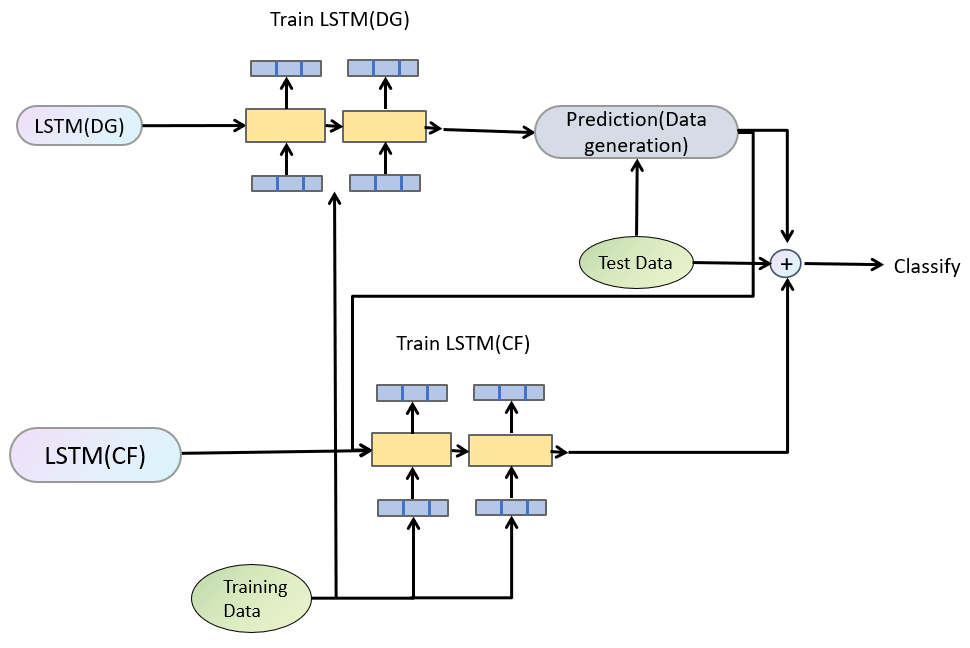

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import sklearn
from sklearn.model_selection import train_test_split
import os


from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Our data cleaning will replace nonsense symbols like '\n' '\r' and etc. with spaces.

We delete website URLs since this content is not related to our task.

We also want to replace a large string of repeating characters as one string.

In [3]:
def data_cleaning(text):
    # 大小写
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\t', ' ')
    text = text.replace("#" , " ")
    text = text.replace("." , "")
    text = text.replace("%", "")



    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    text = re.sub('http?://[A-Za-z0-9./]+', '', text)
    text = re.sub('www.[A-Za-z0-9./]+', '', text)
    text = re.sub("\d+", "", text)
    text = re.sub("!+", "!", text)

#     text = '!'.join(unique_list(text.split('!')))
    text = re.sub(r'((\b\w+\b.{1,2}\w+\b)+).+\1', r'\1', text, flags = re.I)
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

In [4]:
!pwd
#data_folder_path = './data/'
data_folder_path = '/content/drive/MyDrive/toxic-comment-classification/data/'
df = pd.read_csv(data_folder_path + 'train.csv')
test_text = pd.read_csv(data_folder_path + 'test.csv')
test_label = pd.read_csv(data_folder_path + 'test_labels.csv')
test_df = pd.concat([test_text, test_label], axis=1)
classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

/content


In [5]:
df['comment_text'] = df['comment_text'].apply(data_cleaning)
test_df['comment_text'] = test_df['comment_text'].apply(data_cleaning)

## Data augmention

Another approach we experimented with to mitigate the
class imbalance problem is to use data augmentation on the
training set to create additional samples for toxic categories.
We randomly replaced words in toxic comments with their
synonyms at a probability of 0.5. Next, we concatenate the
original dataset with these created samples as our new training
set. We also tried to train another LSTM model to generate text
for the text in datasets which missing some key words. But this
method is too time consuming, which would add complexity
to the overall structure of our solution.

In [6]:

toxic_df = df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)]
non_toxic_df = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)]

replacement_rate =0.3
##  synonym replacement
aug_toxic_df = toxic_df.copy(True)
for i, row in toxic_df.iterrows():
    comment = row['comment_text']
    words = comment.split()
    new_comment = ''
    new_words = []
    for word in words:
        if word in stopwords.words('english'):
            new_words.append(word)
            continue

        random_rate = np.random.uniform(0, 1)

        if random_rate < replacement_rate:
            synonyms = []
            for syn in wordnet.synsets(word):
                for l in syn.lemmas():
                    synonyms.append(l.name())
            if len(synonyms) > 0:
                new_word = synonyms[np.random.randint(0, len(synonyms))]
                new_words.append(new_word)
            else:
                new_words.append(word)


        else:
            new_words.append(word)
    new_comment = ' '.join(new_words)
    new_row = row.copy(True)
    new_row['comment_text'] = new_comment
    aug_toxic_df = aug_toxic_df.append(new_row, ignore_index=True)
    
df = pd.concat([aug_toxic_df, non_toxic_df], ignore_index=True)
df = df.sample(frac=1).reset_index(drop=True)


"\ntoxic_df = df[(df['toxic'] == 1) | (df['severe_toxic'] == 1) | (df['obscene'] == 1) | (df['threat'] == 1) | (df['insult'] == 1) | (df['identity_hate'] == 1)]\nnon_toxic_df = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0) & (df['obscene'] == 0) & (df['threat'] == 0) & (df['insult'] == 0) & (df['identity_hate'] == 0)]\n\nreplacement_rate =0.3\n##  synonym replacement\naug_toxic_df = toxic_df.copy(True)\nfor i, row in toxic_df.iterrows():\n    comment = row['comment_text']\n    words = comment.split()\n    new_comment = ''\n    new_words = []\n    for word in words:\n        if word in stopwords.words('english'):\n            new_words.append(word)\n            continue\n\n        random_rate = np.random.uniform(0, 1)\n\n        if random_rate < replacement_rate:\n            synonyms = []\n            for syn in wordnet.synsets(word):\n                for l in syn.lemmas():\n                    synonyms.append(l.name())\n            if len(synonyms) > 0:\n                new_word =

In [7]:
test_df[0:20]
ids_to_drop = []
for i in range(len(test_df)):
    if test_df['toxic'][i] == -1 or test_df['severe_toxic'][i] == -1 or test_df['obscene'][i] == -1 or test_df['threat'][i] == -1 or test_df['insult'][i] == -1 or test_df['identity_hate'][i] == -1:
        ids_to_drop.append(i)

test_df = test_df.drop(ids_to_drop)

test_df.head()

,id,comment_text,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding I think very highl...,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,""" It says it even in Binghamton Universit...",0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,""" == Before adding a new product to the l...",00059ace3e3e9a53,0,0,0,0,0,0


In [8]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [8]:
from torchtext.vocab import GloVe, vocab

unk_token = "<pad>"
unk_index = 0
#name = "vector_cache"


if os.path.isdir("/content/drive/MyDrive/toxic-comment-classification/.vector_cache"):
    glove_vectors = GloVe(name = 'twitter.27B', cache = './.vector_cache', dim=200)
else:    
    glove_vectors = GloVe('twitter.27B', dim=200)
print(len(glove_vectors.stoi))
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<pad>",unk_index)
#this is necessary otherwise it will throw runtime error if OOV token is queried
glove_vocab.set_default_index(unk_index)
pretrained_embeddings = glove_vectors.vectors
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
print(pretrained_embeddings.shape)


./.vector_cache/glove.twitter.27B.zip: 1.52GB [04:44, 5.34MB/s]                            
100%|█████████▉| 1193513/1193514 [01:14<00:00, 16101.55it/s]


1193514
torch.Size([1193515, 200])


In [9]:
import torch
import pandas as pd
from collections import Counter

class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data_frame,
        sequence_length,
    ):
        #self.args = args
        self.sequence_length = sequence_length
        self.train_df = data_frame
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()

        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]
    
    def load_words(self):
        #train_df = pd.read_csv('data/reddit-cleanjokes.csv')
        text = self.train_df['comment_text'].str.cat(sep=' ')
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]),
        )

In [10]:
dataset = Dataset(df, 4)
dataset_test = Dataset(test_df, 4)

In [ ]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)
    
    def forward(self, x, prev_state):
      embed = self.embedding(x)
      output, state = self.lstm(embed, prev_state)
      logits = self.fc(output)
      return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))


In [ ]:
import argparse
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader

def train(dataset, model):
    model.train()

    dataloader = DataLoader(dataset, batch_size=256)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(2):
        state_h, state_c = model.init_state(4)

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

In [ ]:


model = Model(dataset)

#train(dataset, model)
train(dataset_test, model)
#print(predict(dataset, model, text='Knock knock. Whos there?'))

{'epoch': 0, 'batch': 0, 'loss': 12.538166046142578}
{'epoch': 0, 'batch': 1, 'loss': 12.519558906555176}
{'epoch': 0, 'batch': 2, 'loss': 12.514229774475098}
{'epoch': 0, 'batch': 3, 'loss': 12.515835762023926}
{'epoch': 0, 'batch': 4, 'loss': 12.486090660095215}
{'epoch': 0, 'batch': 5, 'loss': 12.449433326721191}
{'epoch': 0, 'batch': 6, 'loss': 12.368095397949219}
{'epoch': 0, 'batch': 7, 'loss': 12.404167175292969}
{'epoch': 0, 'batch': 8, 'loss': 12.28497314453125}
{'epoch': 0, 'batch': 9, 'loss': 12.266301155090332}
{'epoch': 0, 'batch': 10, 'loss': 12.118127822875977}
{'epoch': 0, 'batch': 11, 'loss': 11.994888305664062}
{'epoch': 0, 'batch': 12, 'loss': 11.518994331359863}
{'epoch': 0, 'batch': 13, 'loss': 11.621477127075195}
{'epoch': 0, 'batch': 14, 'loss': 11.268824577331543}
{'epoch': 0, 'batch': 15, 'loss': 11.301253318786621}
{'epoch': 0, 'batch': 16, 'loss': 10.553515434265137}
{'epoch': 0, 'batch': 17, 'loss': 10.441619873046875}
{'epoch': 0, 'batch': 18, 'loss': 10.09

Save the trained Bi-LSTM (data generation) for futher use

In [8]:
torch.save(model.state_dict(), '/content/drive/MyDrive/toxic-comment-classification/Words_generation_test_model.pkl')

In [9]:
model_gen = Model(dataset)
model_gen.load_state_dict(torch.load('/content/drive/MyDrive/toxic-comment-classification/data/Words_generation_model.pkl'))

In [ ]:
def predict(dataset, model, text, next_words=10):
    model.eval()

    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return words

Data generation example, we set it to predict the following 10 words of a short sentence.

In [ ]:
print(predict(dataset, model_gen, text='Explanation  Why the edits made under my username'))

['Explanation', '', 'Why', 'the', 'edits', 'made', 'under', 'my', 'username', 'humorless', 'Calculus,', 'Kersey', 'Merry', 'little', 'to', 'years', 'that,', 'it!', '']


Add the generated data to training dataset

In [9]:
df_len = len(df)
for a in range(0 , df_len):
    if (df.iloc[a]['toxic'] == 1) | (df.iloc[a]['severe_toxic'] == 1) | (df.iloc[a]['obscene'] == 1) | (df.iloc[a]['threat'] == 1) | (df.iloc[a]['insult'] == 1) | (df.iloc[a]['identity_hate'] == 1):  
      f = df["comment_text"][a]
      following_words = predict(dataset, model_gen, text=f)
      sentence = ' '.join(following_words)
      df["comment_text"][a] = sentence
    

In [11]:
from torch.utils.data import IterableDataset

tokenizer = get_tokenizer("basic_english")



class MyDataset(Dataset):

    def __init__(self, dataframe, max_len=100, pad_token='<pad>'):
         self.X = dataframe['comment_text'].values
         self.Y = dataframe[classes].to_numpy()
         self.max_len = max_len
         self.pad_token = pad_token
         # self.unk_token = unk_token

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        t = idx
        tokens = tokenizer(self.X[t])[:self.max_len]

        diff = self.max_len - len(tokens)
        # print('diff',diff)
        if diff > 0:

            tokens = [self.pad_token] * diff + tokens
            # print('tokens',to
        indices = glove_vocab(tokens)
        result = {
            'text': tokens,
            'indices': torch.tensor(indices),
            'labels': torch.tensor(self.Y[t], dtype=torch.float)
        }
        return result


In [12]:
MAX_LEN = 0
for a in range(0 , len(df)):
    f = df["comment_text"][a]
    length = len(f.split())
    if length > MAX_LEN:
        MAX_LEN = length
        
train_dataset = MyDataset(df, MAX_LEN)
test_dataset = MyDataset(test_df, MAX_LEN)

In [ ]:
print(df['comment_text'].values)

["Explanation  Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC And please don't remove the template from the talk page since I'm retired now"
 "D'aww! He matches this background colour I'm seemingly stuck with Thanks  (talk) :, January ,  (UTC)"
 "Hey man, I'm really not trying to edit war It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page He seems to care more about the formatting than the actual info"
 ...
 'Spitzer     Umm, theres no actual article for prostitution ring  - Crunch Captain'
 'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it'
 '"  And  I came here and my idea was bad right away  What kind of community goes ""you have bad ideas"" go away, instead of helping rewrite them   "']


In [13]:
MAX_LEN

265

In [14]:
for data in test_dataset:
    print(data['text'])
    print(data['labels'])
    print(data['indices'])
    break

['<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 

## Loss Function with Customized Weight

To counter the issue of the imbalanced dataset, we choose to
modify the pos weight parameter in the BCEWithLogitsLoss
loss function, which gives weight to positive samples for each
class. In order to find a suitable weight, we apply the method
proposed by Cui et al. [https://arxiv.org/abs/1901.05555], which is based on the effective
number of samples, is used to handle the imbalance. The weights for each class in the loss function are calculated with
(1 − β)/(1 − βn) where β = (N − 1)/N (we set 0.9999), and n
is the size of samples in the class, N is total number of all
classes.

In [15]:
postive_num = [0, 0, 0, 0, 0, 0]
negative_num = [0, 0, 0, 0, 0, 0]
for data in train_dataset:
    class_num = 0
    for i in data['labels'].tolist():
      if i == 0:
        negative_num[class_num] += 1
      else:
        postive_num[class_num] += 1
      class_num += 1


In [16]:
print(postive_num)
print(negative_num)

[15294, 1595, 8449, 478, 7877, 1405]
[144277, 157976, 151122, 159093, 151694, 158166]


In [ ]:
'''
import numpy as np

neg_weight_set = (1 - 0.9999) / (1 - np.power(0.9999, negative_num))
pos_weight_set = (1 - 0.9999) / (1 - np.power(0.9999, postive_num))
#weight_set = neg_weight_set / pos_weight_set
weight_set = np.sqrt(negative_num / postive_num)
print("weight_set: ", weight_set)
print(neg_weight_set)
print(pos_weight_set)
'''

In [21]:
import numpy as np

pos_weight_set = [0, 0, 0, 0, 0, 0]
neg_weight_set = [0, 0, 0, 0, 0, 0]
weight_set = [0, 0, 0, 0, 0, 0]
weight_set_sqrt = [0, 0, 0, 0, 0, 0]
for num in range(len(postive_num)):
  #weight_set[num] = negative_num[num] / postive_num[num]
  pos_weight_set[num] = (1 - 0.99999) / (1 - np.power(0.99999, postive_num[num]))
  neg_weight_set[num] = (1 - 0.99999) / (1 - np.power(0.99999, negative_num[num]))
  weight_set[num] =  pos_weight_set[num] / neg_weight_set[num]
  weight_set_sqrt[num] =  (negative_num[num] / postive_num[num])
print("pos_weight_set: ", pos_weight_set)
print("neg_weight_set: ", neg_weight_set)
print("weight_set: ", weight_set)
print("weight_set_sqrt: ", weight_set_sqrt)

pos_weight_set:  [7.051219239944264e-05, 0.0006319694045241853, 0.0001234270105584972, 0.002097043732288237, 0.00013201688568263806, 0.0007167519218705336]
neg_weight_set:  [1.3093644095582064e-05, 1.259482186088584e-05, 1.283102381313699e-05, 1.2558624103462118e-05, 1.2810338560280091e-05, 1.258862132858789e-05]
weight_set:  [5.38522292836982, 50.17692282626192, 9.619420270432899, 166.98037261184774, 10.305495445059618, 56.93649075318832]
weight_set_sqrt:  [9.433568719759382, 99.04451410658307, 17.886377086045687, 332.8305439330544, 19.25783927891329, 112.57366548042705]


In [22]:


class TextClassificationModel(nn.Module):

    def __init__(self, pretrained_embeddings, num_class, hidden_size, freeze_embeddings = True):
        super(TextClassificationModel, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze = freeze_embeddings, sparse=False)

        # print(pretrained_embeddings.shape)

        self.lstm = nn.LSTM(pretrained_embeddings.shape[1], hidden_size, num_layers=4, bidirectional=True, dropout=0.2)
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size * 2)
        self.fc2 = nn.Linear(hidden_size * 2, num_class)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)
        
        self.LN = nn.LayerNorm(hidden_size * 4)
        self.LN2 = nn.LayerNorm(hidden_size * 2)

    #def attention_net(self, lstm_output):
    #    attn_weight_matrix = self.W_s2(torch.tanh(self.W_s1(lstm_output)))
    #    attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
    #    attn_weight_matrix = nn.functional.softmax(attn_weight_matrix, dim=2)
    #    return attn_weight_matrix

    def forward(self, indices):
        #print('input', indices.shape)

        embedded = self.embedding(indices.T)
        # print('embedded', embedded.shape)
        self.lstm.flatten_parameters()
        lstm_out, _ = self.lstm(embedded)

        encoding = torch.cat((lstm_out[0], lstm_out[-1]), dim=1)
        
        out = self.LN(encoding)
        out = self.fc1(out)
        out = self.LN2(out)
        out = self.dropout(out)
        out = self.fc2(out)

        #print('output', out.shape)


        #out = self.sigmoid(out)
        #print('out', out)

        return out

In [23]:
train_dataset

In [24]:
from torch.utils.data import DataLoader


BATCH_SIZE = 256

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [25]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

### Traning and Showing results for each epoch

Here we are using function with weights

               precision    recall  f1-score   support

        toxic       0.37      0.35      0.36      6090
 severe_toxic       0.05      0.61      0.09       367
      obscene       0.30      0.36      0.33      3691
       threat       0.03      0.60      0.06       211
       insult       0.27      0.38      0.32      3427
identity_hate       0.05      0.47      0.10       712

    micro avg       0.18      0.38      0.25     14498
    macro avg       0.18      0.46      0.21     14498
 weighted avg       0.30      0.38      0.32     14498
  samples avg       0.02      0.03      0.02     14498

Epoch: 0 Train_Loss: 0.8293197999875515 Train_Accuracy: 0.9354080557823181
Epoch: 0 Test_Loss: 0.7179399626255035 Test_Accuracy: 0.9124959707260132


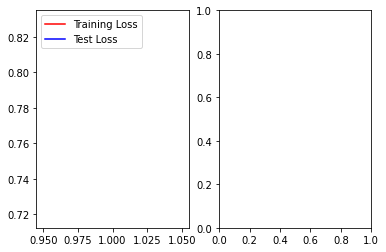

               precision    recall  f1-score   support

        toxic       0.53      0.36      0.43      6090
 severe_toxic       0.09      0.71      0.16       367
      obscene       0.46      0.40      0.43      3691
       threat       0.04      0.66      0.08       211
       insult       0.41      0.41      0.41      3427
identity_hate       0.12      0.49      0.19       712

    micro avg       0.29      0.40      0.34     14498
    macro avg       0.27      0.50      0.28     14498
 weighted avg       0.45      0.40      0.40     14498
  samples avg       0.02      0.03      0.02     14498

Epoch: 1 Train_Loss: 0.6110406999404614 Train_Accuracy: 0.917454719543457
Epoch: 1 Test_Loss: 0.6431703906059265 Test_Accuracy: 0.9403493404388428


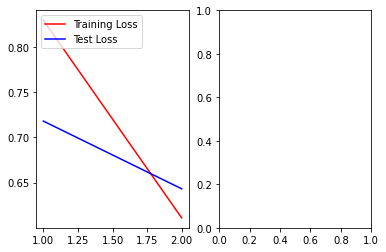

               precision    recall  f1-score   support

        toxic       0.45      0.49      0.47      6090
 severe_toxic       0.08      0.78      0.15       367
      obscene       0.37      0.54      0.44      3691
       threat       0.04      0.70      0.08       211
       insult       0.35      0.55      0.43      3427
identity_hate       0.11      0.57      0.19       712

    micro avg       0.28      0.53      0.36     14498
    macro avg       0.24      0.61      0.29     14498
 weighted avg       0.38      0.53      0.43     14498
  samples avg       0.03      0.05      0.03     14498

Epoch: 2 Train_Loss: 0.5460332257147783 Train_Accuracy: 0.9248077273368835
Epoch: 2 Test_Loss: 0.5762533595561982 Test_Accuracy: 0.9296268820762634


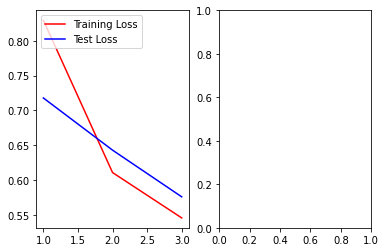

               precision    recall  f1-score   support

        toxic       0.50      0.49      0.49      6090
 severe_toxic       0.07      0.82      0.13       367
      obscene       0.39      0.56      0.46      3691
       threat       0.05      0.67      0.10       211
       insult       0.37      0.56      0.45      3427
identity_hate       0.11      0.59      0.19       712

    micro avg       0.29      0.54      0.38     14498
    macro avg       0.25      0.62      0.30     14498
 weighted avg       0.40      0.54      0.44     14498
  samples avg       0.03      0.05      0.03     14498

Epoch: 3 Train_Loss: 0.5060575445397542 Train_Accuracy: 0.9293553829193115
Epoch: 3 Test_Loss: 0.5712508611679077 Test_Accuracy: 0.9318620562553406


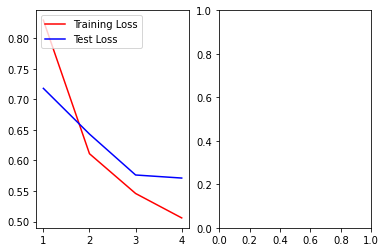

               precision    recall  f1-score   support

        toxic       0.40      0.63      0.49      6090
 severe_toxic       0.06      0.86      0.12       367
      obscene       0.31      0.67      0.42      3691
       threat       0.04      0.73      0.08       211
       insult       0.30      0.67      0.41      3427
identity_hate       0.09      0.70      0.15       712

    micro avg       0.24      0.66      0.35     14498
    macro avg       0.20      0.71      0.28     14498
 weighted avg       0.32      0.66      0.42     14498
  samples avg       0.03      0.06      0.04     14498

Epoch: 4 Train_Loss: 0.47733140397721374 Train_Accuracy: 0.9316604733467102
Epoch: 4 Test_Loss: 0.5402609083652496 Test_Accuracy: 0.909309983253479


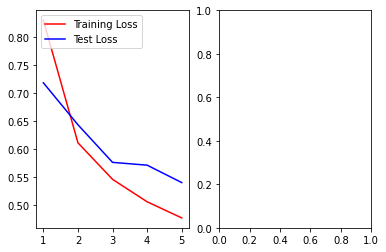

               precision    recall  f1-score   support

        toxic       0.35      0.70      0.47      6090
 severe_toxic       0.06      0.88      0.12       367
      obscene       0.29      0.72      0.41      3691
       threat       0.03      0.81      0.07       211
       insult       0.27      0.72      0.40      3427
identity_hate       0.07      0.76      0.13       712

    micro avg       0.22      0.72      0.33     14498
    macro avg       0.18      0.77      0.27     14498
 weighted avg       0.29      0.72      0.41     14498
  samples avg       0.04      0.07      0.04     14498

Epoch: 5 Train_Loss: 0.4547222250451644 Train_Accuracy: 0.9334151744842529
Epoch: 5 Test_Loss: 0.5328731211423874 Test_Accuracy: 0.891501784324646


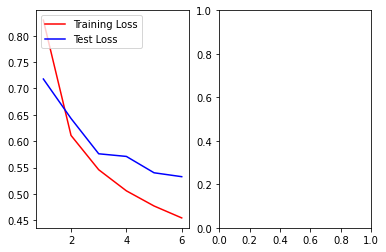

               precision    recall  f1-score   support

        toxic       0.52      0.56      0.54      6090
 severe_toxic       0.09      0.82      0.16       367
      obscene       0.45      0.59      0.51      3691
       threat       0.06      0.69      0.11       211
       insult       0.41      0.61      0.49      3427
identity_hate       0.12      0.66      0.20       712

    micro avg       0.33      0.60      0.42     14498
    macro avg       0.27      0.66      0.33     14498
 weighted avg       0.44      0.60      0.49     14498
  samples avg       0.03      0.05      0.04     14498

Epoch: 6 Train_Loss: 0.43393491853315097 Train_Accuracy: 0.9366593360900879
Epoch: 6 Test_Loss: 0.5203411239385605 Test_Accuracy: 0.9383408427238464


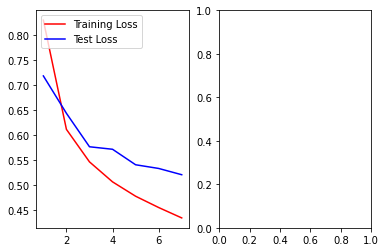

               precision    recall  f1-score   support

        toxic       0.51      0.59      0.55      6090
 severe_toxic       0.10      0.84      0.18       367
      obscene       0.44      0.63      0.52      3691
       threat       0.05      0.79      0.09       211
       insult       0.39      0.66      0.49      3427
identity_hate       0.10      0.73      0.18       712

    micro avg       0.31      0.63      0.41     14498
    macro avg       0.26      0.70      0.33     14498
 weighted avg       0.43      0.63      0.49     14498
  samples avg       0.03      0.05      0.04     14498

Epoch: 7 Train_Loss: 0.41491294444467014 Train_Accuracy: 0.9382635951042175
Epoch: 7 Test_Loss: 0.4951303768157959 Test_Accuracy: 0.9324663877487183


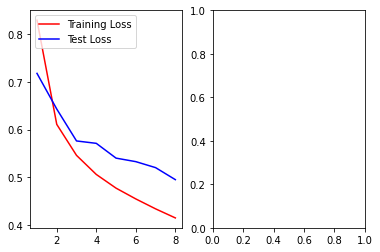

               precision    recall  f1-score   support

        toxic       0.58      0.54      0.56      6090
 severe_toxic       0.10      0.82      0.18       367
      obscene       0.52      0.57      0.54      3691
       threat       0.06      0.77      0.10       211
       insult       0.46      0.59      0.52      3427
identity_hate       0.13      0.64      0.22       712

    micro avg       0.35      0.57      0.44     14498
    macro avg       0.31      0.66      0.35     14498
 weighted avg       0.49      0.57      0.51     14498
  samples avg       0.03      0.05      0.03     14498

Epoch: 8 Train_Loss: 0.4025719472183249 Train_Accuracy: 0.9404528141021729
Epoch: 8 Test_Loss: 0.5190578711628914 Test_Accuracy: 0.944301187992096


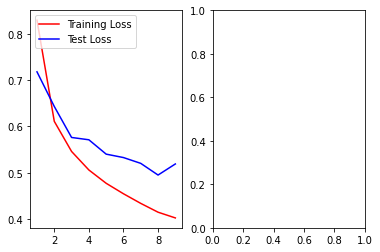

               precision    recall  f1-score   support

        toxic       0.45      0.67      0.54      6090
 severe_toxic       0.08      0.90      0.14       367
      obscene       0.39      0.69      0.50      3691
       threat       0.04      0.86      0.07       211
       insult       0.35      0.71      0.47      3427
identity_hate       0.10      0.73      0.18       712

    micro avg       0.27      0.69      0.39     14498
    macro avg       0.24      0.76      0.32     14498
 weighted avg       0.38      0.69      0.48     14498
  samples avg       0.04      0.06      0.04     14498

Epoch: 9 Train_Loss: 0.38714345446668375 Train_Accuracy: 0.9399504065513611
Epoch: 9 Test_Loss: 0.4903533523082733 Test_Accuracy: 0.9186491370201111


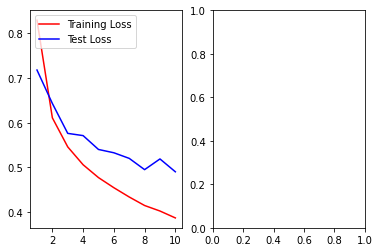

               precision    recall  f1-score   support

        toxic       0.59      0.56      0.57      6090
 severe_toxic       0.11      0.82      0.19       367
      obscene       0.52      0.61      0.56      3691
       threat       0.05      0.82      0.09       211
       insult       0.47      0.61      0.53      3427
identity_hate       0.13      0.66      0.22       712

    micro avg       0.36      0.60      0.45     14498
    macro avg       0.31      0.68      0.36     14498
 weighted avg       0.50      0.60      0.53     14498
  samples avg       0.03      0.05      0.04     14498

Epoch: 10 Train_Loss: 0.37595962685270184 Train_Accuracy: 0.9428060054779053
Epoch: 10 Test_Loss: 0.4866623898744583 Test_Accuracy: 0.9438687562942505


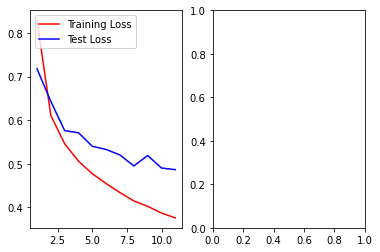

               precision    recall  f1-score   support

        toxic       0.43      0.72      0.54      6090
 severe_toxic       0.08      0.92      0.14       367
      obscene       0.37      0.74      0.49      3691
       threat       0.04      0.88      0.08       211
       insult       0.33      0.75      0.46      3427
identity_hate       0.08      0.80      0.15       712

    micro avg       0.26      0.74      0.39     14498
    macro avg       0.22      0.80      0.31     14498
 weighted avg       0.36      0.74      0.47     14498
  samples avg       0.04      0.07      0.04     14498

Epoch: 11 Train_Loss: 0.3650443204320394 Train_Accuracy: 0.9435266852378845
Epoch: 11 Test_Loss: 0.46024658846855165 Test_Accuracy: 0.9106802940368652


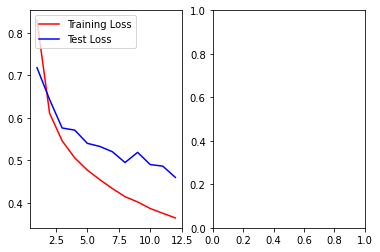

               precision    recall  f1-score   support

        toxic       0.44      0.71      0.55      6090
 severe_toxic       0.09      0.89      0.16       367
      obscene       0.38      0.74      0.50      3691
       threat       0.05      0.83      0.10       211
       insult       0.35      0.75      0.48      3427
identity_hate       0.10      0.78      0.17       712

    micro avg       0.29      0.74      0.41     14498
    macro avg       0.23      0.78      0.32     14498
 weighted avg       0.37      0.74      0.48     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 12 Train_Loss: 0.3586972564554367 Train_Accuracy: 0.9440499544143677
Epoch: 12 Test_Loss: 0.4507150384187698 Test_Accuracy: 0.920795738697052


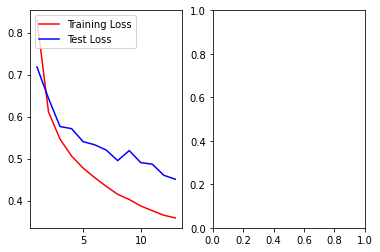

               precision    recall  f1-score   support

        toxic       0.49      0.67      0.57      6090
 severe_toxic       0.08      0.92      0.14       367
      obscene       0.41      0.72      0.53      3691
       threat       0.05      0.85      0.09       211
       insult       0.39      0.72      0.50      3427
identity_hate       0.11      0.75      0.19       712

    micro avg       0.30      0.71      0.42     14498
    macro avg       0.25      0.77      0.34     14498
 weighted avg       0.41      0.71      0.51     14498
  samples avg       0.04      0.06      0.04     14498

Epoch: 13 Train_Loss: 0.3468842897325372 Train_Accuracy: 0.9452991485595703
Epoch: 13 Test_Loss: 0.4573968191742897 Test_Accuracy: 0.9260162711143494


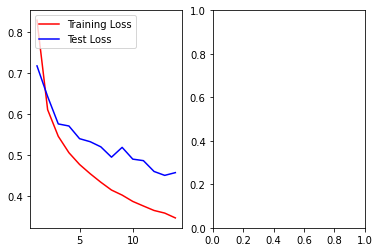

               precision    recall  f1-score   support

        toxic       0.60      0.59      0.59      6090
 severe_toxic       0.11      0.88      0.19       367
      obscene       0.53      0.65      0.58      3691
       threat       0.06      0.78      0.12       211
       insult       0.48      0.65      0.55      3427
identity_hate       0.12      0.73      0.21       712

    micro avg       0.37      0.64      0.47     14498
    macro avg       0.32      0.71      0.37     14498
 weighted avg       0.51      0.64      0.54     14498
  samples avg       0.03      0.05      0.04     14498

Epoch: 14 Train_Loss: 0.3432282920544728 Train_Accuracy: 0.9458119869232178
Epoch: 14 Test_Loss: 0.4721747240424156 Test_Accuracy: 0.9447935819625854


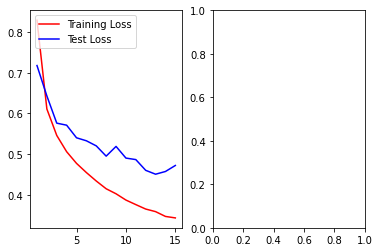

               precision    recall  f1-score   support

        toxic       0.52      0.66      0.59      6090
 severe_toxic       0.09      0.90      0.16       367
      obscene       0.48      0.69      0.56      3691
       threat       0.05      0.83      0.10       211
       insult       0.42      0.71      0.52      3427
identity_hate       0.13      0.71      0.21       712

    micro avg       0.33      0.69      0.45     14498
    macro avg       0.28      0.75      0.36     14498
 weighted avg       0.45      0.69      0.53     14498
  samples avg       0.04      0.06      0.04     14498

Epoch: 15 Train_Loss: 0.33486703680589414 Train_Accuracy: 0.9468846321105957
Epoch: 15 Test_Loss: 0.4592032372355461 Test_Accuracy: 0.9364287257194519


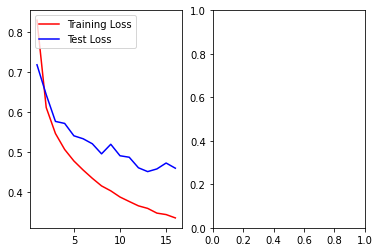

               precision    recall  f1-score   support

        toxic       0.59      0.60      0.60      6090
 severe_toxic       0.11      0.87      0.19       367
      obscene       0.52      0.65      0.58      3691
       threat       0.07      0.78      0.13       211
       insult       0.47      0.66      0.55      3427
identity_hate       0.12      0.71      0.21       712

    micro avg       0.37      0.64      0.47     14498
    macro avg       0.31      0.71      0.37     14498
 weighted avg       0.50      0.64      0.54     14498
  samples avg       0.03      0.05      0.04     14498

Epoch: 16 Train_Loss: 0.3241867679290665 Train_Accuracy: 0.9475144743919373
Epoch: 16 Test_Loss: 0.4821629424095154 Test_Accuracy: 0.9451999664306641


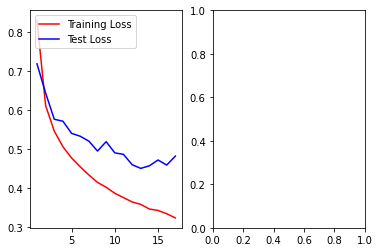

               precision    recall  f1-score   support

        toxic       0.53      0.66      0.59      6090
 severe_toxic       0.09      0.89      0.17       367
      obscene       0.46      0.72      0.56      3691
       threat       0.07      0.80      0.12       211
       insult       0.43      0.71      0.53      3427
identity_hate       0.11      0.77      0.19       712

    micro avg       0.34      0.70      0.46     14498
    macro avg       0.28      0.76      0.36     14498
 weighted avg       0.45      0.70      0.53     14498
  samples avg       0.04      0.06      0.04     14498

Epoch: 17 Train_Loss: 0.32182978198696405 Train_Accuracy: 0.9482173919677734
Epoch: 17 Test_Loss: 0.45691210705041885 Test_Accuracy: 0.9371894001960754


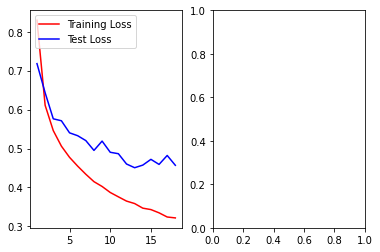

               precision    recall  f1-score   support

        toxic       0.48      0.72      0.58      6090
 severe_toxic       0.08      0.91      0.15       367
      obscene       0.44      0.74      0.55      3691
       threat       0.08      0.79      0.14       211
       insult       0.40      0.74      0.52      3427
identity_hate       0.10      0.79      0.18       712

    micro avg       0.32      0.74      0.45     14498
    macro avg       0.26      0.78      0.35     14498
 weighted avg       0.42      0.74      0.52     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 18 Train_Loss: 0.31355423843249297 Train_Accuracy: 0.9490498304367065
Epoch: 18 Test_Loss: 0.442812464594841 Test_Accuracy: 0.9309502840042114


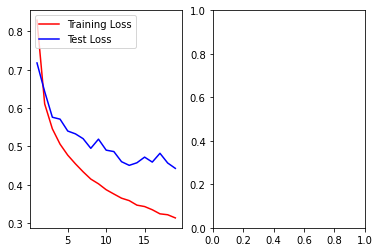

               precision    recall  f1-score   support

        toxic       0.37      0.82      0.51      6090
 severe_toxic       0.06      0.95      0.12       367
      obscene       0.32      0.83      0.46      3691
       threat       0.05      0.84      0.09       211
       insult       0.28      0.84      0.42      3427
identity_hate       0.07      0.85      0.13       712

    micro avg       0.23      0.83      0.37     14498
    macro avg       0.19      0.86      0.29     14498
 weighted avg       0.31      0.83      0.44     14498
  samples avg       0.04      0.08      0.05     14498

Epoch: 19 Train_Loss: 0.30899239918933463 Train_Accuracy: 0.9499104619026184
Epoch: 19 Test_Loss: 0.4722396948337555 Test_Accuracy: 0.8911735415458679


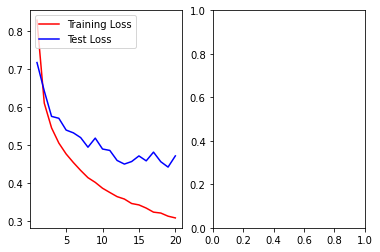

               precision    recall  f1-score   support

        toxic       0.48      0.72      0.57      6090
 severe_toxic       0.07      0.93      0.14       367
      obscene       0.41      0.76      0.54      3691
       threat       0.08      0.78      0.14       211
       insult       0.38      0.76      0.51      3427
identity_hate       0.09      0.81      0.17       712

    micro avg       0.30      0.75      0.43     14498
    macro avg       0.25      0.79      0.34     14498
 weighted avg       0.40      0.75      0.51     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 20 Train_Loss: 0.30155276571615386 Train_Accuracy: 0.9503459930419922
Epoch: 20 Test_Loss: 0.45075302803516387 Test_Accuracy: 0.9257218837738037


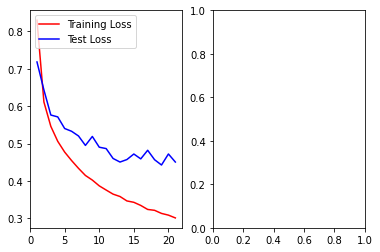

               precision    recall  f1-score   support

        toxic       0.58      0.62      0.60      6090
 severe_toxic       0.09      0.89      0.17       367
      obscene       0.54      0.68      0.60      3691
       threat       0.05      0.82      0.10       211
       insult       0.48      0.67      0.56      3427
identity_hate       0.11      0.77      0.20       712

    micro avg       0.35      0.67      0.46     14498
    macro avg       0.31      0.74      0.37     14498
 weighted avg       0.50      0.67      0.55     14498
  samples avg       0.03      0.06      0.04     14498

Epoch: 21 Train_Loss: 0.29650027140115315 Train_Accuracy: 0.9504202008247375
Epoch: 21 Test_Loss: 0.47292475479841234 Test_Accuracy: 0.9405733346939087


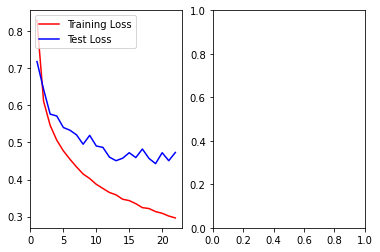

               precision    recall  f1-score   support

        toxic       0.50      0.72      0.59      6090
 severe_toxic       0.09      0.91      0.16       367
      obscene       0.43      0.76      0.55      3691
       threat       0.09      0.76      0.17       211
       insult       0.39      0.76      0.52      3427
identity_hate       0.10      0.80      0.19       712

    micro avg       0.33      0.75      0.46     14498
    macro avg       0.27      0.79      0.36     14498
 weighted avg       0.42      0.75      0.52     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 22 Train_Loss: 0.29111375662092215 Train_Accuracy: 0.9517090320587158
Epoch: 22 Test_Loss: 0.44600738322734834 Test_Accuracy: 0.9327191114425659


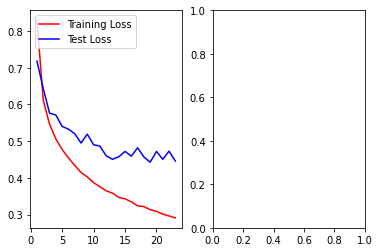

               precision    recall  f1-score   support

        toxic       0.47      0.75      0.57      6090
 severe_toxic       0.07      0.93      0.14       367
      obscene       0.40      0.79      0.53      3691
       threat       0.07      0.82      0.13       211
       insult       0.36      0.79      0.50      3427
identity_hate       0.08      0.83      0.15       712

    micro avg       0.29      0.78      0.42     14498
    macro avg       0.24      0.82      0.34     14498
 weighted avg       0.39      0.78      0.51     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 23 Train_Loss: 0.2879533368903093 Train_Accuracy: 0.9520808458328247
Epoch: 23 Test_Loss: 0.4413374225497246 Test_Accuracy: 0.9197224378585815


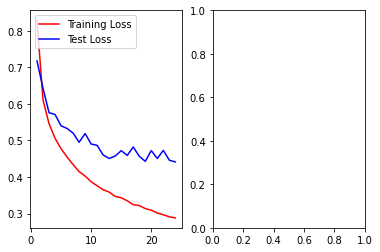

               precision    recall  f1-score   support

        toxic       0.45      0.76      0.57      6090
 severe_toxic       0.08      0.92      0.15       367
      obscene       0.40      0.79      0.53      3691
       threat       0.06      0.82      0.12       211
       insult       0.36      0.80      0.50      3427
identity_hate       0.10      0.81      0.17       712

    micro avg       0.30      0.79      0.43     14498
    macro avg       0.24      0.82      0.34     14498
 weighted avg       0.38      0.79      0.50     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 24 Train_Loss: 0.28543172693118835 Train_Accuracy: 0.9522229433059692
Epoch: 24 Test_Loss: 0.4325306694507599 Test_Accuracy: 0.9223222732543945


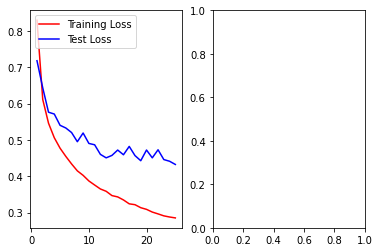

               precision    recall  f1-score   support

        toxic       0.55      0.67      0.61      6090
 severe_toxic       0.09      0.91      0.17       367
      obscene       0.47      0.73      0.57      3691
       threat       0.08      0.81      0.14       211
       insult       0.43      0.73      0.55      3427
identity_hate       0.12      0.74      0.21       712

    micro avg       0.36      0.71      0.47     14498
    macro avg       0.29      0.77      0.37     14498
 weighted avg       0.46      0.71      0.55     14498
  samples avg       0.04      0.06      0.04     14498

Epoch: 25 Train_Loss: 0.27578280116312015 Train_Accuracy: 0.952820360660553
Epoch: 25 Test_Loss: 0.46723738265037534 Test_Accuracy: 0.9402737617492676


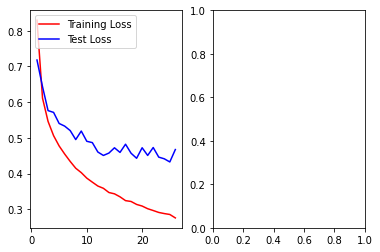

               precision    recall  f1-score   support

        toxic       0.53      0.70      0.61      6090
 severe_toxic       0.10      0.90      0.17       367
      obscene       0.47      0.75      0.57      3691
       threat       0.09      0.78      0.16       211
       insult       0.43      0.74      0.54      3427
identity_hate       0.12      0.76      0.21       712

    micro avg       0.36      0.73      0.48     14498
    macro avg       0.29      0.77      0.38     14498
 weighted avg       0.45      0.73      0.55     14498
  samples avg       0.04      0.06      0.05     14498

Epoch: 26 Train_Loss: 0.27510863731209284 Train_Accuracy: 0.9535525441169739
Epoch: 26 Test_Loss: 0.4607553599476814 Test_Accuracy: 0.9400627613067627


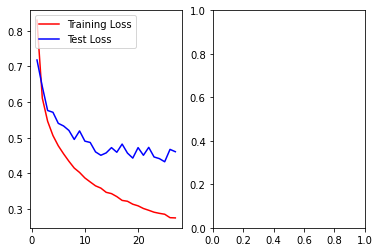

               precision    recall  f1-score   support

        toxic       0.47      0.75      0.58      6090
 severe_toxic       0.08      0.92      0.15       367
      obscene       0.42      0.78      0.55      3691
       threat       0.06      0.82      0.11       211
       insult       0.37      0.79      0.51      3427
identity_hate       0.10      0.79      0.17       712

    micro avg       0.31      0.77      0.44     14498
    macro avg       0.25      0.81      0.34     14498
 weighted avg       0.40      0.77      0.52     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 27 Train_Loss: 0.27300189587120444 Train_Accuracy: 0.953423023223877
Epoch: 27 Test_Loss: 0.435118794798851 Test_Accuracy: 0.9252399802207947


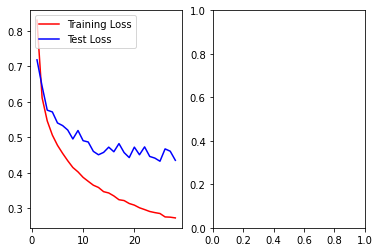

               precision    recall  f1-score   support

        toxic       0.52      0.72      0.60      6090
 severe_toxic       0.09      0.92      0.17       367
      obscene       0.48      0.74      0.58      3691
       threat       0.10      0.74      0.18       211
       insult       0.43      0.75      0.54      3427
identity_hate       0.11      0.79      0.19       712

    micro avg       0.35      0.74      0.48     14498
    macro avg       0.29      0.78      0.38     14498
 weighted avg       0.45      0.74      0.55     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 28 Train_Loss: 0.26643874677710044 Train_Accuracy: 0.9545917510986328
Epoch: 28 Test_Loss: 0.445856355369091 Test_Accuracy: 0.9384788870811462


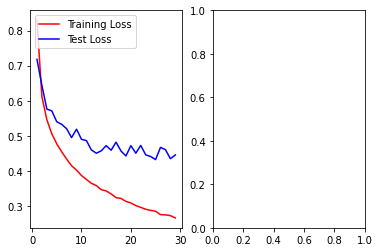

               precision    recall  f1-score   support

        toxic       0.44      0.78      0.57      6090
 severe_toxic       0.07      0.94      0.14       367
      obscene       0.38      0.82      0.52      3691
       threat       0.08      0.79      0.15       211
       insult       0.35      0.82      0.49      3427
identity_hate       0.10      0.81      0.17       712

    micro avg       0.29      0.80      0.43     14498
    macro avg       0.24      0.83      0.34     14498
 weighted avg       0.37      0.80      0.50     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 29 Train_Loss: 0.2580850487574935 Train_Accuracy: 0.9554889798164368
Epoch: 29 Test_Loss: 0.444702011346817 Test_Accuracy: 0.9198657274246216


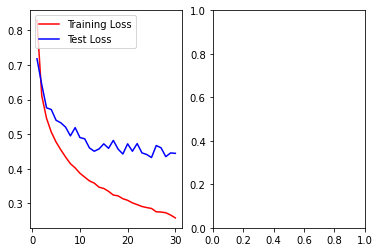

               precision    recall  f1-score   support

        toxic       0.48      0.75      0.58      6090
 severe_toxic       0.08      0.93      0.15       367
      obscene       0.41      0.79      0.54      3691
       threat       0.09      0.78      0.15       211
       insult       0.36      0.81      0.50      3427
identity_hate       0.11      0.79      0.19       712

    micro avg       0.32      0.78      0.45     14498
    macro avg       0.25      0.81      0.35     14498
 weighted avg       0.40      0.78      0.52     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 30 Train_Loss: 0.26198794724992835 Train_Accuracy: 0.9543859958648682
Epoch: 30 Test_Loss: 0.44593516081571577 Test_Accuracy: 0.9282957315444946


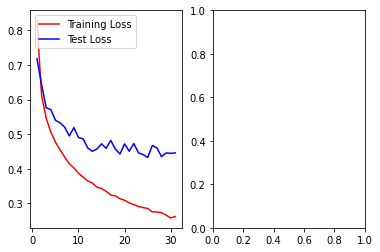

               precision    recall  f1-score   support

        toxic       0.46      0.78      0.58      6090
 severe_toxic       0.08      0.94      0.15       367
      obscene       0.40      0.80      0.53      3691
       threat       0.08      0.81      0.14       211
       insult       0.35      0.81      0.49      3427
identity_hate       0.11      0.79      0.19       712

    micro avg       0.31      0.80      0.45     14498
    macro avg       0.25      0.82      0.35     14498
 weighted avg       0.39      0.80      0.51     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 31 Train_Loss: 0.25726758908384884 Train_Accuracy: 0.9549114108085632
Epoch: 31 Test_Loss: 0.4391098933815956 Test_Accuracy: 0.9248570203781128


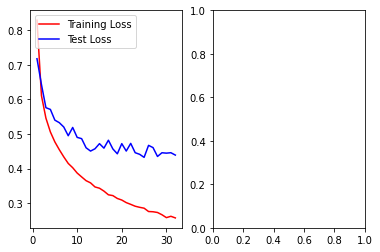

               precision    recall  f1-score   support

        toxic       0.47      0.76      0.58      6090
 severe_toxic       0.07      0.94      0.13       367
      obscene       0.41      0.79      0.54      3691
       threat       0.07      0.83      0.12       211
       insult       0.36      0.81      0.50      3427
identity_hate       0.08      0.86      0.14       712

    micro avg       0.29      0.79      0.42     14498
    macro avg       0.24      0.83      0.34     14498
 weighted avg       0.39      0.79      0.51     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 32 Train_Loss: 0.2504843932886918 Train_Accuracy: 0.9555798172950745
Epoch: 32 Test_Loss: 0.44672054988145826 Test_Accuracy: 0.9177348017692566


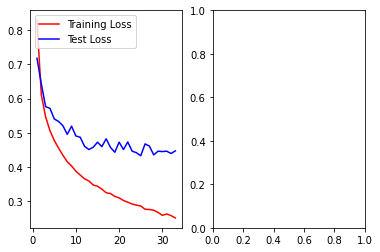

               precision    recall  f1-score   support

        toxic       0.55      0.68      0.61      6090
 severe_toxic       0.10      0.91      0.18       367
      obscene       0.49      0.74      0.59      3691
       threat       0.09      0.78      0.17       211
       insult       0.44      0.74      0.55      3427
identity_hate       0.11      0.78      0.20       712

    micro avg       0.36      0.72      0.48     14498
    macro avg       0.30      0.77      0.38     14498
 weighted avg       0.47      0.72      0.56     14498
  samples avg       0.04      0.06      0.05     14498

Epoch: 33 Train_Loss: 0.2529677933511826 Train_Accuracy: 0.9554022550582886
Epoch: 33 Test_Loss: 0.4471073703169823 Test_Accuracy: 0.9419227838516235


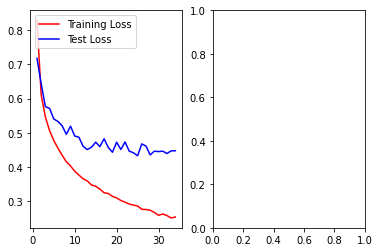

               precision    recall  f1-score   support

        toxic       0.44      0.79      0.57      6090
 severe_toxic       0.09      0.92      0.16       367
      obscene       0.42      0.80      0.55      3691
       threat       0.09      0.80      0.16       211
       insult       0.36      0.82      0.50      3427
identity_hate       0.08      0.85      0.15       712

    micro avg       0.30      0.80      0.44     14498
    macro avg       0.25      0.83      0.35     14498
 weighted avg       0.38      0.80      0.51     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 34 Train_Loss: 0.2479169052094221 Train_Accuracy: 0.956256628036499
Epoch: 34 Test_Loss: 0.44218741500377656 Test_Accuracy: 0.9223952293395996


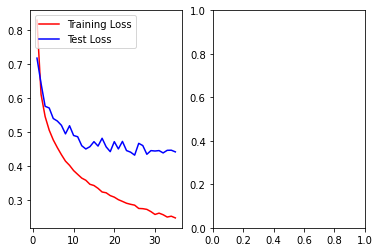

               precision    recall  f1-score   support

        toxic       0.55      0.70      0.62      6090
 severe_toxic       0.09      0.92      0.17       367
      obscene       0.48      0.75      0.58      3691
       threat       0.10      0.76      0.18       211
       insult       0.42      0.76      0.54      3427
identity_hate       0.12      0.77      0.21       712

    micro avg       0.36      0.74      0.49     14498
    macro avg       0.29      0.78      0.38     14498
 weighted avg       0.46      0.74      0.55     14498
  samples avg       0.04      0.06      0.05     14498

Epoch: 35 Train_Loss: 0.241255382863948 Train_Accuracy: 0.9571559429168701
Epoch: 35 Test_Loss: 0.46855387699604034 Test_Accuracy: 0.9410631060600281


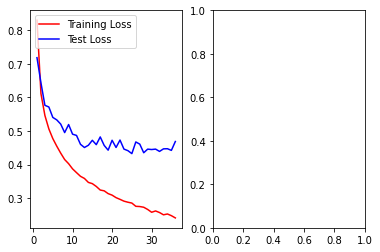

               precision    recall  f1-score   support

        toxic       0.48      0.77      0.59      6090
 severe_toxic       0.08      0.93      0.15       367
      obscene       0.42      0.79      0.55      3691
       threat       0.11      0.73      0.20       211
       insult       0.37      0.81      0.51      3427
identity_hate       0.11      0.80      0.19       712

    micro avg       0.33      0.79      0.46     14498
    macro avg       0.26      0.80      0.36     14498
 weighted avg       0.40      0.79      0.52     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 36 Train_Loss: 0.23894939308938307 Train_Accuracy: 0.9575381875038147
Epoch: 36 Test_Loss: 0.4726840329170227 Test_Accuracy: 0.9308512806892395


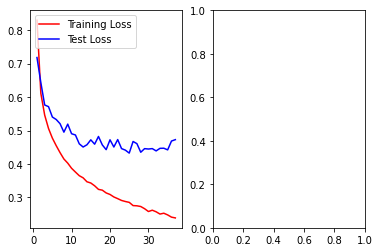

               precision    recall  f1-score   support

        toxic       0.40      0.82      0.54      6090
 severe_toxic       0.08      0.93      0.15       367
      obscene       0.36      0.84      0.50      3691
       threat       0.08      0.83      0.14       211
       insult       0.31      0.85      0.45      3427
identity_hate       0.08      0.85      0.14       712

    micro avg       0.27      0.83      0.41     14498
    macro avg       0.22      0.85      0.32     14498
 weighted avg       0.34      0.83      0.47     14498
  samples avg       0.04      0.08      0.05     14498

Epoch: 37 Train_Loss: 0.2373991611485298 Train_Accuracy: 0.9570807218551636
Epoch: 37 Test_Loss: 0.4485958653688431 Test_Accuracy: 0.9090260863304138


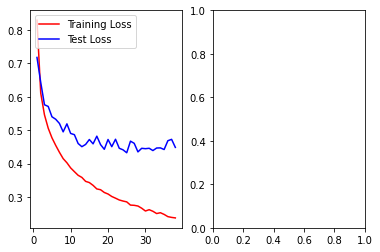

               precision    recall  f1-score   support

        toxic       0.54      0.71      0.62      6090
 severe_toxic       0.10      0.89      0.19       367
      obscene       0.49      0.75      0.60      3691
       threat       0.10      0.76      0.18       211
       insult       0.43      0.76      0.55      3427
identity_hate       0.13      0.76      0.22       712

    micro avg       0.37      0.74      0.50     14498
    macro avg       0.30      0.77      0.39     14498
 weighted avg       0.46      0.74      0.56     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 38 Train_Loss: 0.23384250124964195 Train_Accuracy: 0.9578943848609924
Epoch: 38 Test_Loss: 0.4870512994527817 Test_Accuracy: 0.9434754252433777


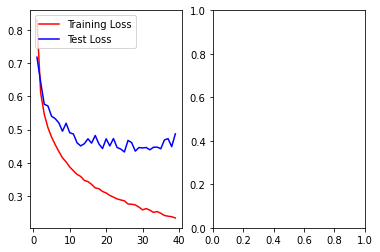

               precision    recall  f1-score   support

        toxic       0.54      0.72      0.62      6090
 severe_toxic       0.10      0.91      0.18       367
      obscene       0.50      0.76      0.60      3691
       threat       0.09      0.76      0.16       211
       insult       0.43      0.77      0.55      3427
identity_hate       0.12      0.78      0.20       712

    micro avg       0.37      0.75      0.49     14498
    macro avg       0.30      0.78      0.39     14498
 weighted avg       0.47      0.75      0.56     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 39 Train_Loss: 0.23501020038309386 Train_Accuracy: 0.9576290845870972
Epoch: 39 Test_Loss: 0.4835284666419029 Test_Accuracy: 0.9414252042770386


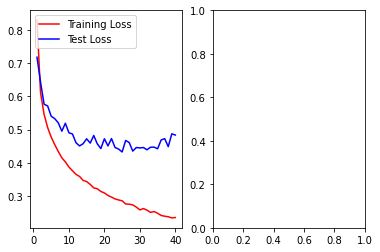

               precision    recall  f1-score   support

        toxic       0.53      0.72      0.61      6090
 severe_toxic       0.10      0.92      0.18       367
      obscene       0.46      0.77      0.58      3691
       threat       0.09      0.79      0.16       211
       insult       0.40      0.79      0.53      3427
identity_hate       0.11      0.79      0.20       712

    micro avg       0.35      0.76      0.48     14498
    macro avg       0.28      0.80      0.38     14498
 weighted avg       0.45      0.76      0.55     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 40 Train_Loss: 0.22766210557892919 Train_Accuracy: 0.9588845372200012
Epoch: 40 Test_Loss: 0.47396591770648955 Test_Accuracy: 0.9376400709152222


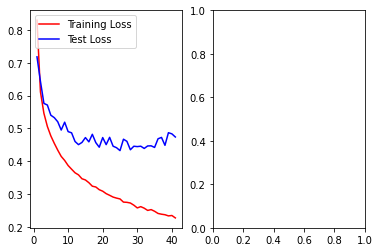

               precision    recall  f1-score   support

        toxic       0.52      0.73      0.61      6090
 severe_toxic       0.11      0.89      0.19       367
      obscene       0.49      0.75      0.59      3691
       threat       0.11      0.73      0.19       211
       insult       0.44      0.76      0.56      3427
identity_hate       0.14      0.73      0.23       712

    micro avg       0.38      0.74      0.51     14498
    macro avg       0.30      0.76      0.40     14498
 weighted avg       0.46      0.74      0.56     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 41 Train_Loss: 0.22595861167288744 Train_Accuracy: 0.9588385820388794
Epoch: 41 Test_Loss: 0.5009578421711922 Test_Accuracy: 0.945155680179596


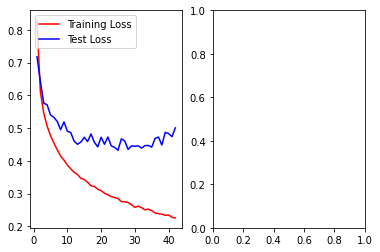

               precision    recall  f1-score   support

        toxic       0.50      0.75      0.60      6090
 severe_toxic       0.09      0.91      0.17       367
      obscene       0.45      0.78      0.57      3691
       threat       0.10      0.78      0.18       211
       insult       0.40      0.79      0.53      3427
identity_hate       0.11      0.80      0.19       712

    micro avg       0.34      0.78      0.48     14498
    macro avg       0.28      0.80      0.37     14498
 weighted avg       0.43      0.78      0.54     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 42 Train_Loss: 0.2239110481996949 Train_Accuracy: 0.9595759510993958
Epoch: 42 Test_Loss: 0.47642650836706163 Test_Accuracy: 0.935363233089447


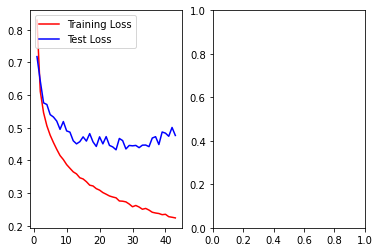

               precision    recall  f1-score   support

        toxic       0.50      0.75      0.60      6090
 severe_toxic       0.09      0.92      0.17       367
      obscene       0.45      0.78      0.57      3691
       threat       0.13      0.73      0.21       211
       insult       0.40      0.79      0.53      3427
identity_hate       0.10      0.80      0.18       712

    micro avg       0.34      0.77      0.48     14498
    macro avg       0.28      0.79      0.38     14498
 weighted avg       0.43      0.77      0.54     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 43 Train_Loss: 0.22336919584239906 Train_Accuracy: 0.9591957926750183
Epoch: 43 Test_Loss: 0.4802322867512703 Test_Accuracy: 0.9357540011405945


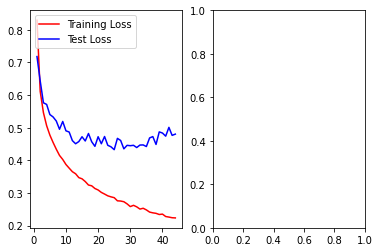

               precision    recall  f1-score   support

        toxic       0.49      0.76      0.60      6090
 severe_toxic       0.09      0.92      0.16       367
      obscene       0.43      0.80      0.56      3691
       threat       0.10      0.78      0.18       211
       insult       0.40      0.79      0.53      3427
identity_hate       0.11      0.80      0.19       712

    micro avg       0.34      0.78      0.47     14498
    macro avg       0.27      0.81      0.37     14498
 weighted avg       0.42      0.78      0.54     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 44 Train_Loss: 0.22300358097522688 Train_Accuracy: 0.9592459201812744
Epoch: 44 Test_Loss: 0.48052874505519866 Test_Accuracy: 0.9338080286979675


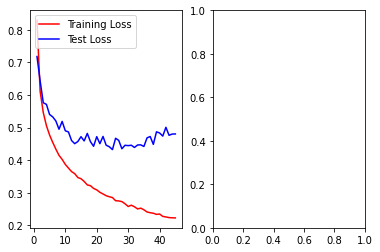

               precision    recall  f1-score   support

        toxic       0.52      0.74      0.61      6090
 severe_toxic       0.10      0.90      0.17       367
      obscene       0.45      0.78      0.57      3691
       threat       0.11      0.76      0.20       211
       insult       0.41      0.78      0.54      3427
identity_hate       0.11      0.80      0.19       712

    micro avg       0.35      0.77      0.48     14498
    macro avg       0.28      0.79      0.38     14498
 weighted avg       0.44      0.77      0.54     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 45 Train_Loss: 0.2197922229145964 Train_Accuracy: 0.9595759510993958
Epoch: 45 Test_Loss: 0.49069442492723464 Test_Accuracy: 0.9372414946556091


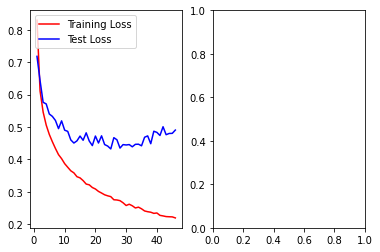

               precision    recall  f1-score   support

        toxic       0.56      0.71      0.63      6090
 severe_toxic       0.10      0.90      0.18       367
      obscene       0.49      0.75      0.60      3691
       threat       0.15      0.70      0.25       211
       insult       0.44      0.76      0.56      3427
identity_hate       0.12      0.77      0.21       712

    micro avg       0.38      0.74      0.50     14498
    macro avg       0.31      0.77      0.40     14498
 weighted avg       0.48      0.74      0.57     14498
  samples avg       0.04      0.07      0.05     14498

Epoch: 46 Train_Loss: 0.21293225817573377 Train_Accuracy: 0.9609745144844055
Epoch: 46 Test_Loss: 0.5550273737311363 Test_Accuracy: 0.9449472427368164


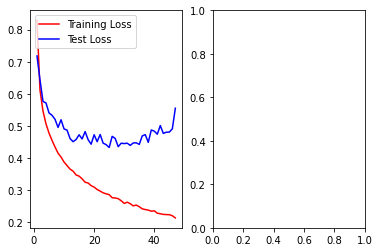

               precision    recall  f1-score   support

        toxic       0.53      0.73      0.61      6090
 severe_toxic       0.10      0.89      0.19       367
      obscene       0.48      0.76      0.59      3691
       threat       0.14      0.73      0.23       211
       insult       0.44      0.76      0.56      3427
identity_hate       0.14      0.72      0.24       712

    micro avg       0.39      0.75      0.51     14498
    macro avg       0.31      0.77      0.40     14498
 weighted avg       0.46      0.75      0.56     14498
  samples avg       0.05      0.07      0.05     14498

Epoch: 47 Train_Loss: 0.21737694632835114 Train_Accuracy: 0.9598527550697327
Epoch: 47 Test_Loss: 0.5301901698708534 Test_Accuracy: 0.9458564519882202


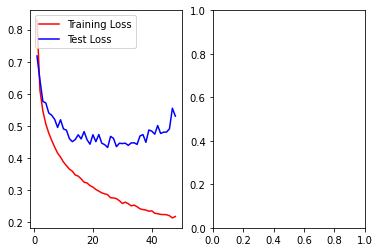

               precision    recall  f1-score   support

        toxic       0.50      0.70      0.59      6090
 severe_toxic       0.12      0.84      0.21       367
      obscene       0.48      0.72      0.58      3691
       threat       0.06      0.78      0.12       211
       insult       0.42      0.73      0.53      3427
identity_hate       0.10      0.77      0.17       712

    micro avg       0.34      0.72      0.46     14498
    macro avg       0.28      0.76      0.37     14498
 weighted avg       0.44      0.72      0.53     14498
  samples avg       0.04      0.06      0.05     14498

Epoch: 48 Train_Loss: 0.2122207168632975 Train_Accuracy: 0.9611207246780396
Epoch: 48 Test_Loss: 0.538444972038269 Test_Accuracy: 0.9361864328384399


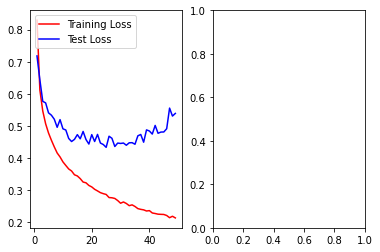

               precision    recall  f1-score   support

        toxic       0.42      0.82      0.55      6090
 severe_toxic       0.08      0.94      0.14       367
      obscene       0.35      0.85      0.49      3691
       threat       0.10      0.79      0.18       211
       insult       0.32      0.85      0.47      3427
identity_hate       0.10      0.82      0.17       712

    micro avg       0.29      0.84      0.43     14498
    macro avg       0.23      0.85      0.33     14498
 weighted avg       0.35      0.84      0.48     14498
  samples avg       0.05      0.08      0.05     14498

Epoch: 49 Train_Loss: 0.216273356288767 Train_Accuracy: 0.9590495824813843
Epoch: 49 Test_Loss: 0.479734867811203 Test_Accuracy: 0.9149760007858276


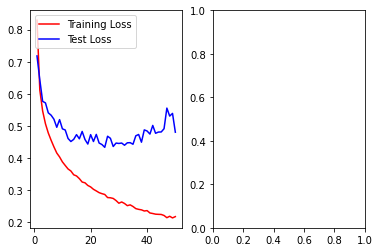

In [26]:
from IPython.display import clear_output
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
weights = []
for cls in classes:
    w = len(df) /df[cls].sum()
    weights.append(w)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor(weight_set))
# loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(weights))
# loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor((175796 - 35098*2) / 35098*2))
model = TextClassificationModel(pretrained_embeddings, len(classes), hidden_size=128)
gpus = torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if gpus > 1:
    print("Let's use", gpus, "GPUs!")
    # model = torch.nn.DataParallel(model)    # multi-gpu

loss_fn.to(device)
model.to(device)
optimizer = AdamW(model.parameters(), lr=4e-5, weight_decay=0.0001)

epochs = 50

training_losses = [ None for i in range(epochs)]
test_losses = [ None for i in range(epochs)]
epoch_count = [i for i in range(1, epochs+1)]
recalls = [ None for i in range(epochs)]
precisions = [ None for i in range(epochs)]
accuracys = [ None for i in range(epochs)]
for e in range(epochs):
    model.train()
    epoch_loss = 0

    losses = []
    correct_predictions = 0
    for batch_id, batch in enumerate(train_dataloader):

        ids = batch['indices'].to(device)
        #print('ids: ', ids.shape)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(ids)
        probs = torch.sigmoid(outputs)
        preds = torch.where(outputs > 0.5, 1, 0)
        loss = loss_fn(outputs, labels)
        #print('loss: ', loss)

        correct_predictions += torch.sum(preds == labels)

        loss.backward()
        optimizer.step()
        # if batch_id % 100 == 0:
            # print('Epoch: {} Batch: {} Loss: {}'.format(e, batch_id, loss.item()))
            #print(loss.grad_fn)

        losses.append(loss.item())

    epoch_loss = np.mean(losses)

    training_losses[e] = epoch_loss
    train_accuracy = correct_predictions/(len(df)*6)


    if e % 3000 == 0 and e != 0:
        torch.save(model.state_dict(), 'model_epoch_{}.pt'.format(e))

    ## Evaluate on test set
    with torch.no_grad():
        model.eval()
        test_loss = []
        test_correct_predictions = 0
        predictions_store = []
        labels_store = []

        for batch_id, batch in enumerate(test_dataloader):
            ids = batch['indices'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids)

            probs = torch.sigmoid(outputs)
            preds = torch.where(outputs > 0.5, 1, 0)
            loss = loss_fn(outputs, labels)

            test_correct_predictions += torch.sum(preds == labels)
            test_loss.append(loss.item())

            labels = labels.to(torch.device("cpu")).numpy()
            preds = preds.to(torch.device("cpu")).numpy()
            for i in range(len(preds)):
                predictions_store.append(preds[i])
                labels_store.append(labels[i])

        # print(pred_counter, label_counter)
        test_loss = np.mean(test_loss)
        accuracy = test_correct_predictions/(len(test_dataset)*6)
        test_losses[e] = test_loss

        rp = classification_report(labels_store, predictions_store, target_names=classes)
        print(rp)
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {}'.format(e, test_loss, accuracy))

        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")

        plt.show()





In [ ]:
        print('Epoch: {} Train_Loss: {} Train_Accuracy: {}'.format(e, epoch_loss, train_accuracy))
        print('Epoch: {} Test_Loss: {} Test_Accuracy: {} Recall: {} Precision: {}'.format(e, test_loss, accuracy, recall_score, precision_score))
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.plot(epoch_count, training_losses, 'r', label='Training Loss')
        ax1.plot(epoch_count, test_losses, 'b', label='Test Loss')
        ax1.legend(loc="upper left")


        ax2.plot(epoch_count, recalls, 'g', label='Recall')
        ax2.legend(loc="upper left")

        plt.show()

In [ ]:
probs = torch.sigmoid(logits)
print(probs)